### Colab Activity 12.3: Evaluation Curves – Precision vs. Recall and ROC

**Estimated Time: 90 Minutes**


This assignment focuses on using the precision-recall curves and receiver operating characteristic (ROC) curves to examine tradeoffs in classifier performance.  Also, these curves and the area they determine can be viewed as a metric itself.  Scikit-learn implements all of this, and by the end of this activity, you should be comfortable with these functions.

#### Index

- [Problem 1](#Problem-1)
- [Problem 2](#Problem-2)
- [Problem 3](#Problem-3)
- [Problem 4](#Problem-4)
- [Problem 5](#Problem-5)
- [Problem 6](#Problem-6)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, recall_score, precision_score, precision_recall_curve, roc_curve
from sklearn.datasets import load_breast_cancer
from sklearn.compose import make_column_transformer
from sklearn import set_config

set_config(display="diagram")

### The Data


For this exercise, you will again use the credit card default data.  It is loaded and split below.  A pipeline for model building is also instantiated and fit. 

In [2]:
default = pd.read_csv('data/default.csv', index_col=0)

In [3]:
default.head()

,default,student,balance,income
1,No,No,729.526495,44361.625074
2,No,Yes,817.180407,12106.134700
3,No,No,1073.549164,31767.138947
4,No,No,529.250605,35704.493935
5,No,No,785.655883,38463.495879


In [4]:
transformer = make_column_transformer((OneHotEncoder(drop = 'if_binary'), ['student']),
                                     remainder = StandardScaler())
X_train, X_test, y_train, y_test = train_test_split(default.drop('default', axis = 1), default.default,
                                                   random_state=42,
                                                   stratify = default.default)
knn_pipe = Pipeline([('transform', transformer), ('knn', KNeighborsClassifier(n_neighbors = 10))])

In [5]:
knn_pipe.fit(X_train, y_train)

Pipeline(steps=[('transform',
                 ColumnTransformer(remainder=StandardScaler(),
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['student'])])),
                ('knn', KNeighborsClassifier(n_neighbors=10))])

In [6]:
test_predictions = knn_pipe.predict_proba(X_test)

[Back to top](#-Index)

### Problem 1

#### Precision for different thresholds



Below, complete the function `precision_thresh` to take in a NumPy array of predicted probabilities and return a prediction for the positive class at or above that threshold (`thresh`) and negative prediction for the ones below.  

The function should use the `precision_score` function to return the precision score between `y_test` and `preds` with `pos_label='Yes'`.

In [7]:

def precision_thresh(predict_probs, 
                  y_test, 
                  thresh):
    preds = np.where(predict_probs >= thresh, 'Yes', 'No')
    
    return precision_score(y_test, preds, pos_label='Yes')


# Answer check
print(precision_thresh(test_predictions[:, 1], y_test, 0.1))
print(precision_thresh(test_predictions[:, 1], y_test, 0.9))

0.18658892128279883
0.75


[Back to top](#-Index)

### Problem 2

#### Determining precision for multiple thresholds



Now, create a DataFrame called `results_df`. This DataFrame will have a column named `threshold'` with values from the `thresholds` list. The DataFrame will also have a column named `precision`. This column should contain the precision values at each threshold calculated using the `precision_thresh` function. 



In [8]:
thresholds = np.arange(0, 1, .1)
thresholds

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [9]:

results_df = pd.DataFrame({'threshold': thresholds, 'precision': [precision_thresh(test_predictions[:, 1], y_test, i) for i in thresholds]})



# Answer check
results_df

,threshold,precision
0,0.0,0.033200
1,0.1,0.186589
2,0.2,0.303571
3,0.3,0.500000
4,0.4,0.500000
5,0.5,0.559322
6,0.6,0.558824
7,0.7,0.736842
8,0.8,0.736842
9,0.9,0.750000


In [10]:
##Uncomment to visualize precision changes
# plt.plot(precision_df['threshold'], precision_df['precision'], '--o', label = 'precision')
# plt.xticks(thresholds)
# plt.xlabel('Threshold')
# plt.ylabel('Precision')
# plt.grid();

[Back to top](#-Index)

### Problem 3

#### A Recall threshold function



Similar to your `precision_thresh` function, complete the function `recall_thresh` below to compute the recall given a threshold.  Your function should use the `recall_score` function to return the recall score between `y_test` and `preds` with `pos_label='Yes'`.


Inside the `result_df` DataFrame, add a column called `recall`. This column should contain the recall values at each threshold calculated using the `recall_thresh` function. 

In [11]:

def recall_thresh(predict_probs, 
                  y_test, 
                  thresh):
    preds = np.where(predict_probs >= thresh, 'Yes', 'No')
    
    return recall_score(y_test, preds, pos_label='Yes')
results_df['recall'] = [recall_thresh(test_predictions[:, 1], y_test, i) for i in thresholds]


# Answer check
print(recall_thresh(test_predictions[:, 1], y_test, 0.1))
print(recall_thresh(test_predictions[:, 1], y_test, 0.9))
results_df

0.7710843373493976
0.07228915662650602


,threshold,precision,recall
0,0.0,0.033200,1.000000
1,0.1,0.186589,0.771084
2,0.2,0.303571,0.614458
3,0.3,0.500000,0.445783
4,0.4,0.500000,0.445783
5,0.5,0.559322,0.397590
6,0.6,0.558824,0.228916
7,0.7,0.736842,0.168675
8,0.8,0.736842,0.168675
9,0.9,0.750000,0.072289


[Back to top](#-Index)

### Problem 4

#### Precision vs. Recall Tradeoff


As you see in the plot below based, on the `results_df`, improving the precision involves a decrease in recall.  

<center>
    <img src = 'images/precall.png'/>
</center>

scikit learn implements a function `precision_recall_curve` that takes as arguments `y_true`, `probas_pred`, `pos_label=None`. 

The function returns the values for precision, recall, and the decision thresholds.  Use the probabilities in `test_predictions` in the `precision_recall_curve` function, and assign the results to `precision`, `recall`, and `boundaries` below.  Uncomment the plot to visualize your results.

In [12]:

precision, recall, boundaries = precision_recall_curve(y_test, test_predictions[:, 1], pos_label='Yes')


# Answer check
print(boundaries[:5])
# plt.plot(precision, recall, '--o')
# plt.xticks(boundaries);
# plt.grid()
# plt.ylabel('Recall')
# plt.xlabel('Precision')
# plt.title('Precision vs Recall from sklearn');

[0.  0.1 0.2 0.3 0.4]


[Back to top](#-Index)

### Problem 5

#### ROC Curve



Similar to the `precision_recall_curve`, the `roc_curve` function takes in `y_true` and `y_score`, which can be predicted probabilities.  The function returns the false positive rates, true positive rates, and thresholds.  Assign these to `fpr`, `tpr`, and `thresh_rocs` below.  Uncomment the code to visualize the ROC curve. 

In [13]:

fpr, tpr, thresh_rocs = roc_curve(y_test, test_predictions[:, 1], pos_label='Yes')


# Answer check
print('False Positive Rates: ', fpr[:5])
print('True Positive Rates: ', tpr[:5])
# plt.plot(fpr, tpr, '--o', label = 'roc curve')
# plt.plot(tpr, tpr, label = 'baseline')
# plt.legend()
# plt.title('ROC Curve')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.grid();

False Positive Rates:  [0.         0.00041374 0.00082747 0.00206868 0.00620604]
True Positive Rates:  [0.         0.01204819 0.07228916 0.1686747  0.22891566]


[Back to top](#-Index)

### Problem 6

#### Area Under Curve as metric



Finally, consider the proposed area under the curve scoring method described in the lectures.  Below, construct a grid search named `roc_grid` that uses the `knn_pipe` and searches over the number of neighbors from 1 to 31 by odd values, choosing the model that optimizes `roc_auc_score`.  Identify the optimal number of neighbors and assign them to `best_k` below.  

In [14]:

roc_grid = GridSearchCV(knn_pipe, param_grid={'knn__n_neighbors': range(1, 33, 2)}, scoring = 'roc_auc')
roc_grid.fit(X_train, y_train)
best_k = roc_grid.best_params_['knn__n_neighbors']


# Answer check
best_k

29

#### Visualizing with scikitlearn

Below, we use the `RocCurveDisplay` to display roc curves for three knn models.  You can either use predictions or estimators to create the visualization.  Below, we use the `from_estimator` method.

In [15]:
from sklearn.metrics import RocCurveDisplay

In [16]:
knn_1 = Pipeline([('transform', transformer), ('knn', KNeighborsClassifier(n_neighbors = 1))])
knn_1.fit(X_train, y_train)

Pipeline(steps=[('transform',
                 ColumnTransformer(remainder=StandardScaler(),
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['student'])])),
                ('knn', KNeighborsClassifier(n_neighbors=1))])

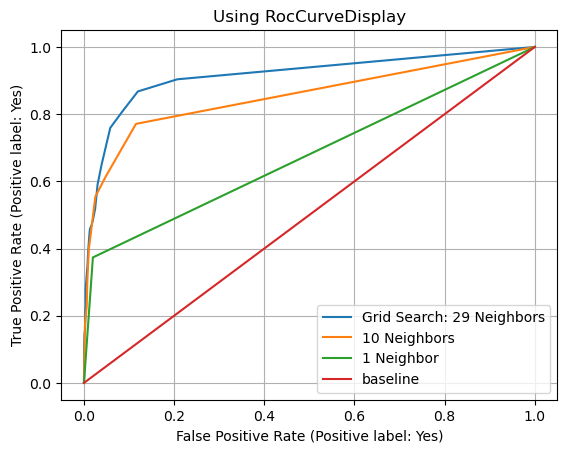

In [17]:
fig, ax = plt.subplots()
RocCurveDisplay.from_estimator(roc_grid, X_test, y_test, pos_label = 'Yes', ax = ax, label = 'Grid Search: 29 Neighbors')
RocCurveDisplay.from_estimator(knn_pipe, X_test, y_test, pos_label = 'Yes', ax = ax, label = '10 Neighbors')
RocCurveDisplay.from_estimator(knn_1, X_test, y_test, ax = ax, label = '1 Neighbor')
plt.grid()
plt.plot(np.arange(0, 1.1, .1), np.arange(0, 1.1, .1), label = 'baseline');
plt.title('Using RocCurveDisplay')
plt.legend();